In [42]:
% cd C:\Users\wolfg\Desktop\Uni\UCL\Macroeconomic Policy

import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import scipy
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR, SVAR
# from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.base.datetools import dates_from_str

% matplotlib inline
from pylab import rcParams
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt

df = pd.read_excel('Exer1new.xls', sheet_name='data')

C:\Users\wolfg\Desktop\Uni\UCL\Macroeconomic Policy


In [43]:
# Get per capita variables

df['pop'] = pd.to_numeric(df['pop'], errors='coerce')
df.dropna(inplace = True)
df['gdp'] = np.log(df['gdp']/df['pop'])
df['cons'] = np.log(df['cons']/df['pop'])
df['gov'] = np.log(df['gov']/df['pop'])
del df['consndur']
del df['defense']
del df['pop']
df['date'] = df['date'].astype(str)

In [44]:
df[['year','quarter']] = df['date'].str.split('.',expand=True)
df['quarter'] = df['quarter'].apply(lambda x: '1' if x == '0' else ('2' if x == '25' else ('3' if x == '5' else '4')))
dates = df[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]

In [45]:
quarterly = dates_from_str(quarterly)
df.index = pd.DatetimeIndex(quarterly, freq = 'Q')
del df['year']
del df['quarter']
del df['date']
df_original = df
df.head()

,gdp,cons,gov
1948-03-31,-3.9446,-4.4257,-5.3487
1948-06-30,-3.9306,-4.4163,-5.3179
1948-09-30,-3.9280,-4.4177,-5.3010
1948-12-31,-3.9286,-4.4115,-5.2670
1949-03-31,-3.9443,-4.4117,-5.2416


In [46]:
df.dtypes

gdp     float64
cons    float64
gov     float64
dtype: object

In [47]:
columns = ['gdp', 'cons', 'gov']
lags = 4

In [48]:
def produce_lags(data, columns, lags):

    covariates = []

    for col in columns:
    
        for lag in range(1,lags+1):
        
            data[col + "_" + str(lag)] = data[col].shift(periods = lag)
        
            covariates.append(col + "_" + str(lag))

    df = data.dropna()
                 
    return df, covariates
#covariates.append('t')
#df['t'] = range(1,len(df)+1)

In [49]:
[df, covariates] = produce_lags(df, columns, lags)

In [50]:
def OLS_reg(data, x, y):
    
    # here we include a constant and a trend variable to achieve trend stationarity
    # can be implemented such that it needs to be specified
    
    constant = np.ones(len(data))
    trend = np.array(range(1, len(data)+1))
    ct = np.stack((constant, trend), axis=1)
    x = np.array(data[x])
    x = np.append(ct, x, axis = 1)
    y = np.array(data[y])
    xTx = np.matmul(x.T,x)
    xTy = np.matmul(x.T,y)
    xTx_inv = np.linalg.inv(xTx)
    beta = np.matmul(xTx_inv, xTy)
    residuals = y - np.matmul(x, beta)
    
    return beta, residuals

In [51]:
def run_VAR(data, covariates, columns):

    reduced_form_coefficients = []
    reduced_form_residuals = []

    for i in columns:
    
        [beta, res] = OLS_reg(data, covariates, i)
    
        reduced_form_coefficients.append(beta)
        reduced_form_residuals.append(res)
    
    reduced_form_coefficients = np.vstack((reduced_form_coefficients))
    reduced_form_residuals = np.vstack((reduced_form_residuals))
    
    return reduced_form_coefficients, reduced_form_residuals

In [52]:
[reduced_form_coefficients, reduced_form_residuals] = run_VAR(df, covariates, columns)

In [53]:
VCOV = np.cov(reduced_form_residuals)
correlation = np.corrcoef(reduced_form_residuals)

In [54]:
correlation

array([[ 1.        ,  0.61397802,  0.2688248 ],
       [ 0.61397802,  1.        , -0.0720625 ],
       [ 0.2688248 , -0.0720625 ,  1.        ]])

In [55]:
# Obtain structural shock matrix A0 as given by this structure:

#[1 0 a_g^y]
#[0 1 a_g^c]
#[0 0 1]

# Important note: this system is OVERIDENTIFIED because we have put one restriction too much for the system under standard
# identification procedure to be just identified. I don't know what problems this overidentification cause but one would be 
# that we cannot uniquely recover a13 and a23 because we have more equations that unknowns (here we have 5 unknowns and 6 equations)
# so in general there exists no solution.

# However, there exists always a least-squares solution if some equations are a consequence of the others and so they are
# not really independent equations.

# The best solution to overcome this determination issue would be to implement a least-squares estimation in a loop for every
# unknown parameter in A matrix

# Now include the contemporaneous effect of government spending in the other two regressions, either by the variable itself or
# its reduced form residuals

covariates.append('gov_res')
df['gov_res'] = reduced_form_residuals[2]
a0_gov_gdp = OLS_reg(df, covariates, 'gdp')[0][-1]*-1
a0_gov_cons = OLS_reg(df, covariates, 'cons')[0][-1]*-1
a0_gov_gov = 1

# if we would also set 

A0 = np.array([[1, 0, a0_gov_gdp],
              [0, 1, a0_gov_cons],
              [0, 0, a0_gov_gov]])

A0_inv = np.linalg.inv(A0)

C:\Users\wolfg\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
A0_inv

array([[ 1.        ,  0.        ,  0.17132215],
       [ 0.        ,  1.        , -0.03988099],
       [ 0.        ,  0.        ,  1.        ]])

In [57]:
# This is another approach which only works if the system of equation is determined (just identified), otherwise it's meaningless

# We can also identify the contemporaneous factors from the equation: Omega_structural = A0*Omega_reduced*A0'
# Note: the only restriction on Omega_structural we impose is that its diagonal! It can have sigma^2 different from 1 on the
# diagonal!

sigma_3_struct = VCOV[(-1,-1)]
a13 = -VCOV[(0,2)]/sigma_3_struct
a23 = -VCOV[(1,2)]/sigma_3_struct
sigma_2_struct = VCOV[(1,1)] + 2*(a23)*VCOV[(1,2)] + VCOV[(2,2)]*a23**2
sigma_1_struct = VCOV[(0,0)] + 2*(a13)*VCOV[(0,2)] + VCOV[(2,2)]*a13**2

omega_struct = np.array([[sigma_1_struct, 0, 0], [0, sigma_2_struct, 0], [0, 0, sigma_3_struct]])

In [58]:
# What does this matrix tell us? And why is this not identical to the VCOV of structural residuals, i.e. res_struct = A0 * res_reduced
# perhaps because in this case it's overidentified?
omega_struct

array([[6.21823430e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.02814415e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.65027233e-04]])

In [59]:
cholesky = np.linalg.cholesky(VCOV)

# Note: Cholesky decomposition assumes a lower triangular A0 matrix, i.e. the last ordered variable has no contemporaneous
# effect on any of the other variables

In [60]:
def tidy_IRF(columns, reduced_form_coefficients, lags):
    
    merged_coefficients = np.array(())

    for i in range(len(columns)):
    
        merged_coefficients = np.concatenate((merged_coefficients, reduced_form_coefficients[i][2:]))
    
    # Note here: the [2:] corresponds to the exclusion of the first two coefficients, i.e. constant and trend since they
    # don't matter for the computation of IRFs

    merged_coefficients = np.reshape(merged_coefficients,(len(columns)**2,lags)).T

    empty_list = []

    for i in range(len(merged_coefficients)):
    
        obj = np.reshape(merged_coefficients[i], (len(columns),len(columns)))
    
        empty_list.append(obj)
    
    empty_array = np.array(())

    for i in range(len(columns)):
    
        for j in range(len(empty_list)):
        
            obj = empty_list[j][i]
        
            empty_array = np.append(empty_array, obj)
        
    empty_array = np.reshape(empty_array, (len(columns),len(columns)*lags))
    
    return empty_array

In [61]:
empty_array = tidy_IRF(columns,reduced_form_coefficients,lags)

In [62]:
# Create Companion form matrix for Impulse Response Functions
# This is useful if you have a VAR(p) and want to rewrite it in VAR(1) form such that you can convert it into its VMA infinity
# representation

# A good summary can be found here: https://www3.nd.edu/~esims1/arp_companion.pdf and http://pareto.uab.es/lgambetti/Lecture2M.pdf

def create_companion(columns, lags, empty_array):

    Companion = np.zeros((lags*len(columns), lags*len(columns)))

    for i in range(lags*len(columns)):
    
        if i < len(columns):
    
            Companion[(i)] = empty_array[(i)]
    
        if i >= len(columns):
        
            Companion[(i,i-len(columns))] = 1
            
    return Companion

In [63]:
Companion = create_companion(columns, lags, empty_array)

In [64]:
def create_IRF(impulse_var, columns_input, A0_inv, forecast_horizon, Companion):

    #impulse_var = 'gov'
    impulse_index = columns_input.index(impulse_var)
    shock_vector = np.zeros((len(columns_input), 1))
    shock_vector[(impulse_index)] = 1
    shock_vector = np.matmul(A0_inv, shock_vector)

    #forecast_horizon = 20

    IRF = np.zeros((forecast_horizon, len(columns_input)))

    for h in range(forecast_horizon):
    
        if h == 0:
        
            IRF[(h)] = shock_vector.T
        
        elif h > 0:
        
            Companion_comp = np.linalg.matrix_power(Companion,h)
            Companion_selection = Companion_comp[0:len(columns_input), 0:len(columns_input)]
            IRF_calc = np.matmul(Companion_selection, A0_inv).T[impulse_index]
            IRF[(h)] = IRF_calc
            
    return IRF

In [65]:
IRF = create_IRF(impulse_var='gov', columns_input=columns, A0_inv = A0_inv, forecast_horizon=20, Companion = Companion)

In [66]:
#rcParams['figure.figsize'] = 15, 5

def create_IRF_plot(IRF, columns, forecast_horizon, impulse_var):
    
    rcParams['figure.figsize'] = 15, 5

    IRF_df = pd.DataFrame(IRF)
    IRF_df.columns = columns
    # rcParams['figure.figsize'] = 15, 5
    colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

    f, axarr = plt.subplots(1,len(columns), sharex=False, sharey=False)
    f.suptitle('Impulse Response Functions')
    x = range(forecast_horizon)

    for color, i, idx in zip(colors, columns, range(len(columns))):
    
        axarr[idx].plot(x, IRF_df[i], color = color)
        axarr[idx].set(xlabel='t', ylabel='Impulse Response to ' + impulse_var + ' shock')
        axarr[idx].legend()
    
        if (sum(IRF_df[i] > 0) > 0 and sum(IRF_df[i] < 0) > 0):
        
            axarr[idx].axhline(linewidth=1, color='r', linestyle = '--')
        
    f.subplots_adjust(left = None, right = None, hspace=0, wspace = 0.3)
#for ax in axarr.flat:
#    ax.set(xlabel='t', ylabel='Impulse Response to gov shock')

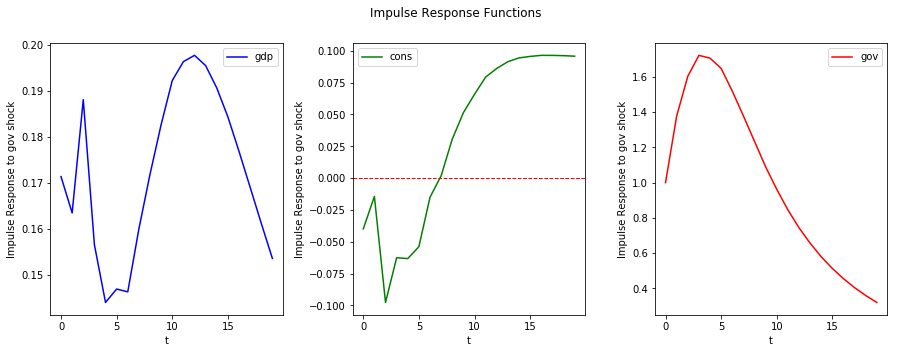

In [67]:
create_IRF_plot(IRF, columns, 20, 'gov')

In [68]:
# Test reduced form residuals for normal distribution

# Jarque-Bera: H0: population of which sample was drawn has skewness and kurtosis matching those of normal distribution

print(scipy.stats.jarque_bera(reduced_form_residuals[0]))
print(scipy.stats.jarque_bera(reduced_form_residuals[1]))
print(scipy.stats.jarque_bera(reduced_form_residuals[2]))

# We reject the Null Hypothesis and conclude that the residuals are NOT normally distributed. However, ADF test showed
# that reduced form residuals as well as structural form residuals didn't have unit-root.

# Kurtosis: H0: population of which sample was drawn has skewness of normal distribution

print(scipy.stats.skewtest(reduced_form_residuals[0]))
print(scipy.stats.skewtest(reduced_form_residuals[1]))
print(scipy.stats.skewtest(reduced_form_residuals[2]))

# Kurtosis: H0: population of which sample was drawn has kurtosis of normal distribution

print(scipy.stats.kurtosistest(reduced_form_residuals[0]))
print(scipy.stats.kurtosistest(reduced_form_residuals[1]))
print(scipy.stats.kurtosistest(reduced_form_residuals[2]))

# The normal distribution tests only tell us whether asymptotic confidence intervals are adequate or whether we should use
# bootstrapping instead

(29.61101723035923, 3.715774129497973e-07)
(123.9061117661658, 0.0)
(108.09959213109943, 0.0)
SkewtestResult(statistic=-0.6415536509125456, pvalue=0.5211630352319864)
SkewtestResult(statistic=-1.1821975937500628, pvalue=0.23712730720100084)
SkewtestResult(statistic=2.7353116059787537, pvalue=0.006232124908025395)
KurtosistestResult(statistic=3.5438946650477754, pvalue=0.0003942627300951591)
KurtosistestResult(statistic=5.154844271919279, pvalue=2.538417945049522e-07)
KurtosistestResult(statistic=4.92051542420224, pvalue=8.631659713503008e-07)


In [69]:
# structural residuals according to res_struct = A0*res_reduced
res_struct = np.matmul(A0, reduced_form_residuals)

       0      1      2
0 1.0000 0.6593 0.0000
1 0.6593 1.0000 0.0000
2 0.0000 0.0000 1.0000


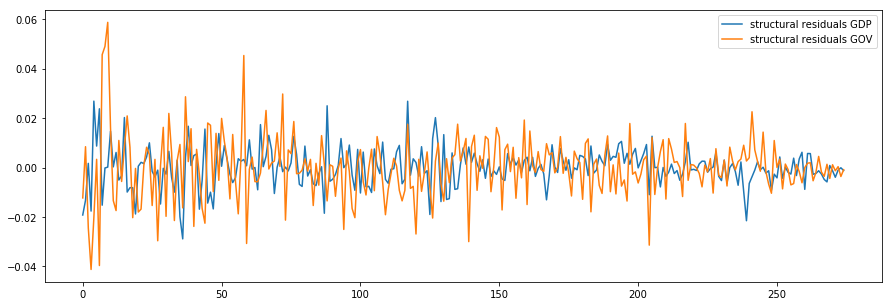

In [70]:
pd.options.display.float_format = '{:.4f}'.format
print(pd.DataFrame(np.corrcoef(res_struct))) # this is omega_structural (rather its correlation counterpart), 
# it's NOT diagonal but the important relationships between government and all the other endogeneous variables are orthogonal

# from this representation we can see that the structural residuals of GDP and consumption are contemporaneously correlated
# BUT structural residuals from government and GDP, and consumption are NOT contemporaneously correlated!

# How can we check? obtain structural residuals from GDP equation and GOV equation according to res_struct = A0*res_reduced

plt.plot(res_struct[0], label = "structural residuals GDP")
plt.plot(res_struct[2], label = "structural residuals GOV")
plt.legend(loc='upper right')
plt.show()

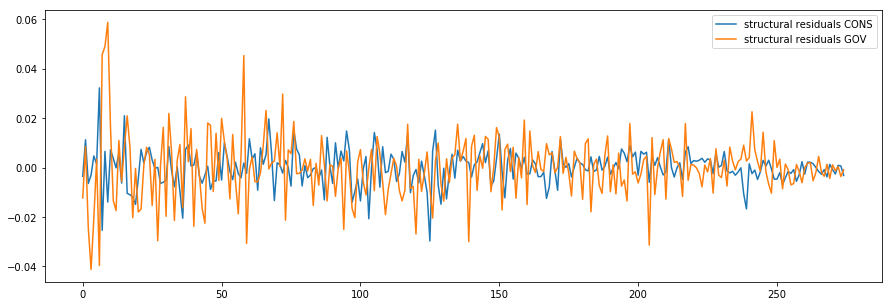

In [71]:
# Same for structural residuals from CONS equation and GOV equation

plt.plot(res_struct[1], label = "structural residuals CONS")
plt.plot(res_struct[2], label = "structural residuals GOV")
plt.legend(loc='upper right')
plt.show()

In [72]:
print(adfuller(df['gdp'])[1]) # unit root
print(adfuller(df['cons'])[1]) # unit root
print(adfuller(df['gov'])[1]) # unit root

print(adfuller(reduced_form_residuals[0])[1]) # no unit root - trend stationary
print(adfuller(reduced_form_residuals[1])[1]) # no unit root - trend stationary
print(adfuller(reduced_form_residuals[2])[1]) # no unit root - trend stationary

print(adfuller(res_struct[0])[1]) # no unit root - trend stationary - so we can proceed with bootstrapping
print(adfuller(res_struct[1])[1]) # no unit root - trend stationary - so we can proceed with bootstrapping
print(adfuller(res_struct[2])[1]) # no unit root - trend stationary - so we can proceed with bootstrapping

# Note here: reduced form residuals from GOV equation coincides with structural form residuals because it was the most endogeneous
# variable, i.e. ordered lastly

0.25590540650627736
0.502142895896139
0.5372924061263679
1.1051092358575445e-29
5.694809082122173e-09
9.216231767061536e-14
9.736608678943428e-30
8.531159103385721e-09
9.216231767061536e-14


In [73]:
# We use model-based resampling (i.e. we draw from the distribution of the residuals that our SVAR model created)

covariates = covariates[:-1] # remove gov_res from dataframe

initialised_y = df_original[columns].iloc[0:lags,:].values # reduced form VAR

In [74]:
def create_random_errors(A0, reduced_form_residuals, columns):
    
    res_struct = np.matmul(A0, reduced_form_residuals)
    
    bootstrapped_sample_errors = np.ones((res_struct.shape[0], res_struct.shape[1]))
    
    # np.random.seed(seed = 123) # disable later!
    
    for idx, var in enumerate(columns):   
        
        bootstrapped_errors = np.random.choice(res_struct[idx], size=len(res_struct[idx]))
        bootstrapped_sample_errors[(idx)] = bootstrapped_errors
    
    A0_inv = np.linalg.inv(A0)
    
    bootstrapped_sample_errors = np.matmul(A0_inv, bootstrapped_sample_errors) #  or directly sample from reduced form residuals?
    
    return bootstrapped_sample_errors

In [75]:
bootstrapped_sample_errors = create_random_errors(A0, reduced_form_residuals, columns)

In [76]:
def create_bootstrapped_ts(columns, initialised_y, bootstrapped_sample_errors, lags, reduced_form_coefficients):

    bootstrapped_ts = np.empty(shape = (0, len(columns)))
    bootstrapped_ts = np.append(bootstrapped_ts, initialised_y.reshape((-1, len(columns))), axis=0)

    bootstrapp_list = []

    for i in range(bootstrapped_sample_errors.shape[1]):

        ct = np.array([1,i+1])
        current_ts = np.flip(bootstrapped_ts[-lags:].T, axis = 1).flatten()
        merged_ts = np.concatenate((ct, current_ts))
        new_ts = np.matmul(reduced_form_coefficients, merged_ts) + bootstrapped_sample_errors.T[i]

        bootstrapped_ts = np.append(bootstrapped_ts, new_ts.reshape((-1, len(columns))), axis=0)
    
        bootstrapp_list.append(list(new_ts))
        
    return np.array(bootstrapp_list)

In [77]:
bootstrapped_ts = create_bootstrapped_ts(columns, initialised_y, bootstrapped_sample_errors, lags, reduced_form_coefficients)

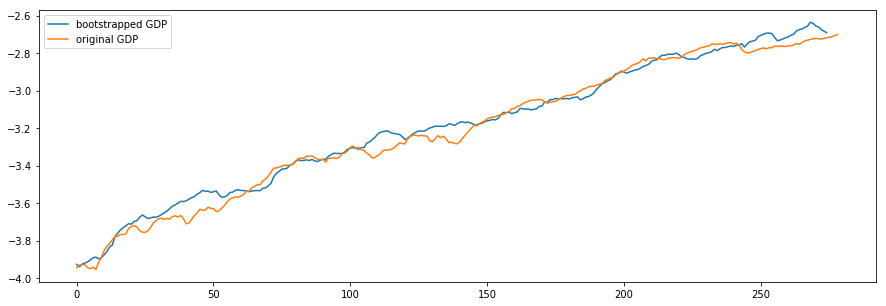

In [78]:
plt.plot(bootstrapped_ts.T[0], label = "bootstrapped GDP")
plt.plot(df_original['gdp'].values, label = "original GDP")
plt.legend(loc='upper left')
plt.show()

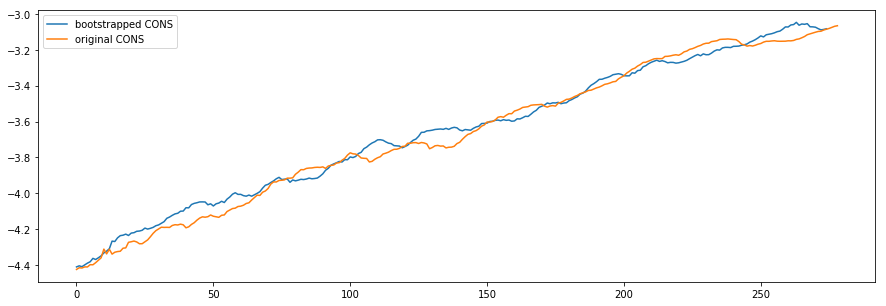

In [79]:
plt.plot(bootstrapped_ts.T[1], label = "bootstrapped CONS")
plt.plot(df_original['cons'].values, label = "original CONS")
plt.legend(loc='upper left')
plt.show()

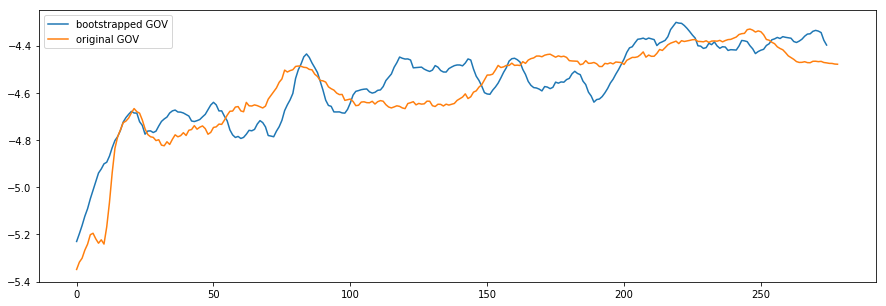

In [80]:
plt.plot(bootstrapped_ts.T[2], label = "bootstrapped GOV")
plt.plot(df_original['gov'].values, label = "original GOV")
plt.legend(loc='upper left')
plt.show()

In [81]:
bootstrapped_df = pd.DataFrame(bootstrapped_ts)
bootstrapped_df.columns = columns
bootstrapped_df.head()

,gdp,cons,gov
0,-3.9267,-4.4115,-5.2302
1,-3.9400,-4.4056,-5.1973
2,-3.9253,-4.4101,-5.1625
3,-3.9203,-4.4006,-5.1232
4,-3.9134,-4.3905,-5.0914


In [82]:
[bootstrapped_df, covariates] = produce_lags(bootstrapped_df, columns, lags)

In [83]:
[reduced_form_coefficients, reduced_form_residuals] = run_VAR(bootstrapped_df, covariates, columns)

In [84]:
empty_array = tidy_IRF(columns=columns, lags=lags, reduced_form_coefficients=reduced_form_coefficients)

In [85]:
Companion = create_companion(columns, lags, empty_array)

In [86]:
IRF = create_IRF(impulse_var='gov', columns_input=columns, A0_inv = A0_inv, forecast_horizon=20, Companion = Companion)

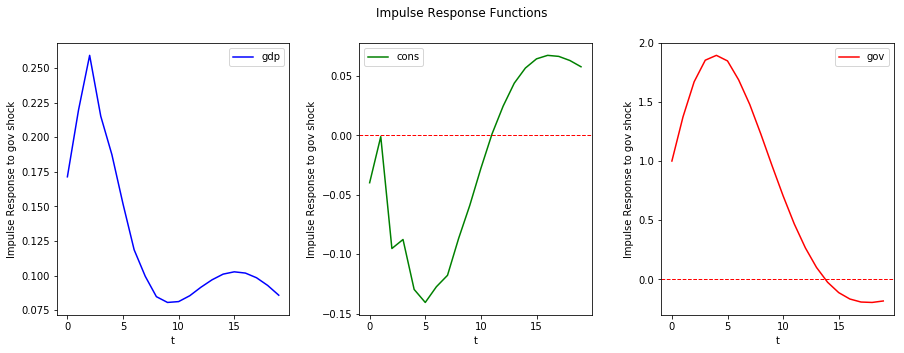

In [87]:
create_IRF_plot(IRF, columns, 20, 'gov')

In [88]:
###########################################################################################################################

# First run

columns = ['gdp', 'cons', 'gov']
lags = 4
[df, covariates] = produce_lags(df, columns, lags)
[orig_reduced_form_coefficients, orig_reduced_form_residuals] = run_VAR(df, covariates, columns)
covariates.append('gov_res')
df['gov_res'] = orig_reduced_form_residuals[2]
a0_gov_gdp = OLS_reg(df, covariates, 'gdp')[0][-1]*-1
a0_gov_cons = OLS_reg(df, covariates, 'cons')[0][-1]*-1
a0_gov_gov = 1

# if we would also set 

A0_orig = np.array([[1, 0, a0_gov_gdp],
              [0, 1, a0_gov_cons],
              [0, 0, a0_gov_gov]])

A0_inv_orig = np.linalg.inv(A0_orig)

empty_array = tidy_IRF(columns, orig_reduced_form_coefficients,lags)
Companion = create_companion(columns, lags, empty_array)
IRF_orig = create_IRF(impulse_var='gov', columns_input=columns, A0_inv = A0_inv_orig, forecast_horizon=20, Companion = Companion)
res_struct_orig = np.matmul(A0_orig, orig_reduced_form_residuals)

covariates = covariates[:-1] # remove gov_res from dataframe
initialised_y = df_original[columns].iloc[0:lags,:].values # reduced form VAR

###########################################################################################################################

iterations = 3

IRF_list = []

for i in range(iterations):
    
    # np.random.seed(seed = 123)
    
    # we have to estimate the structural parameters for A0 in every iteration!
    
    bootstrapped_sample_errors = create_random_errors(A0, orig_reduced_form_residuals, columns)
    bootstrapped_ts = create_bootstrapped_ts(columns, initialised_y, bootstrapped_sample_errors, lags, reduced_form_coefficients=orig_reduced_form_coefficients)
    bootstrapped_df = pd.DataFrame(bootstrapped_ts)
    bootstrapped_df.columns = columns
    [bootstrapped_df, covariates] = produce_lags(bootstrapped_df, columns, lags)
    [reduced_form_coefficients, reduced_form_residuals] = run_VAR(bootstrapped_df, covariates, columns)
    empty_array = tidy_IRF(columns=columns, lags=lags, reduced_form_coefficients=reduced_form_coefficients)
    Companion = create_companion(columns, lags, empty_array)
    IRF = create_IRF(impulse_var='gov', columns_input=columns, A0_inv = A0_inv_orig, forecast_horizon=20, Companion = Companion)
    
    # create_IRF_plot(IRF, columns, 20, 'gov')
    
    IRF_list.append(IRF)

C:\Users\wolfg\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [90]:
# This is correct

model = VAR(df[['gdp', 'cons', 'gov']])
results = model.fit(4, trend = "ct")
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, May, 2019
Time:                     18:52:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -28.5484
Nobs:                     267.000    HQIC:                  -28.8860
Log likelihood:           2791.98    FPE:                2.27320e-13
AIC:                     -29.1127    Det(Omega_mle):     1.95008e-13
--------------------------------------------------------------------
Results for equation gdp
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.015157         0.062742           -0.242           0.809
trend           0.000018         0.000070            0.254           0.799
L1.gdp          0.998396         0.087274           11.440           0.000
L1.cons    

In [91]:
results.resid.head()

,gdp,cons,gov
1951-03-31,0.0070,0.0108,0.0334
1951-06-30,0.0070,-0.0164,0.0543
1951-09-30,0.0120,0.0060,0.0155
1951-12-31,-0.0032,0.0064,-0.0224
1952-03-31,0.0003,-0.0023,-0.0168


In [92]:
model.select_order(15)
results2 = model.fit(maxlags=15, ic='aic')
lag_order = results2.k_ar
lag_order

5

In [93]:
results.forecast(df[['gdp', 'cons', 'gov']].values[-4:], 5)

array([[-2.69493565, -3.05996172, -4.47409024],
       [-2.68911432, -3.05576994, -4.46803305],
       [-2.6827683 , -3.05112691, -4.46082879],
       [-2.67693747, -3.04625153, -4.45289981],
       [-2.67104766, -3.04144315, -4.44500289]])

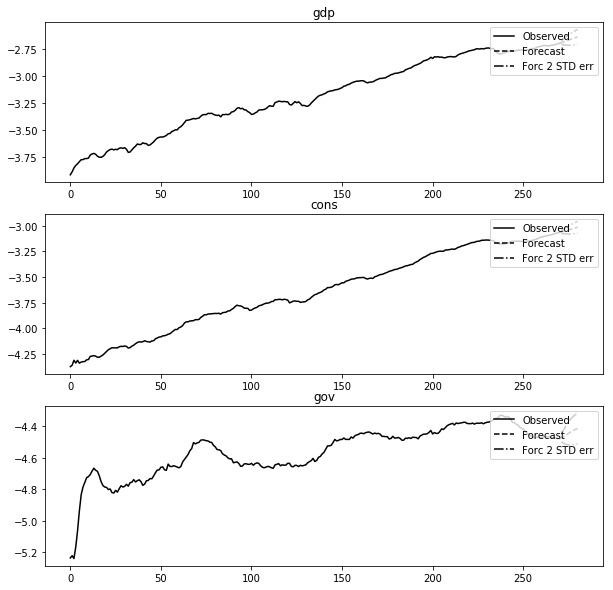

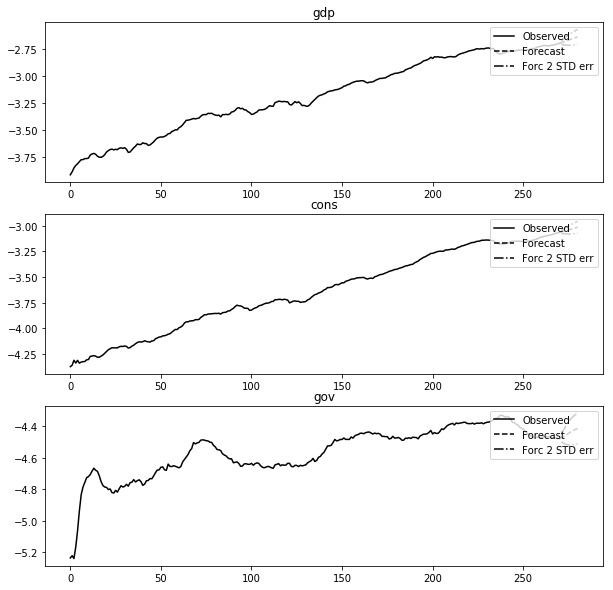

In [94]:
results.plot_forecast(10)

In [95]:
irf = results.irf(20)

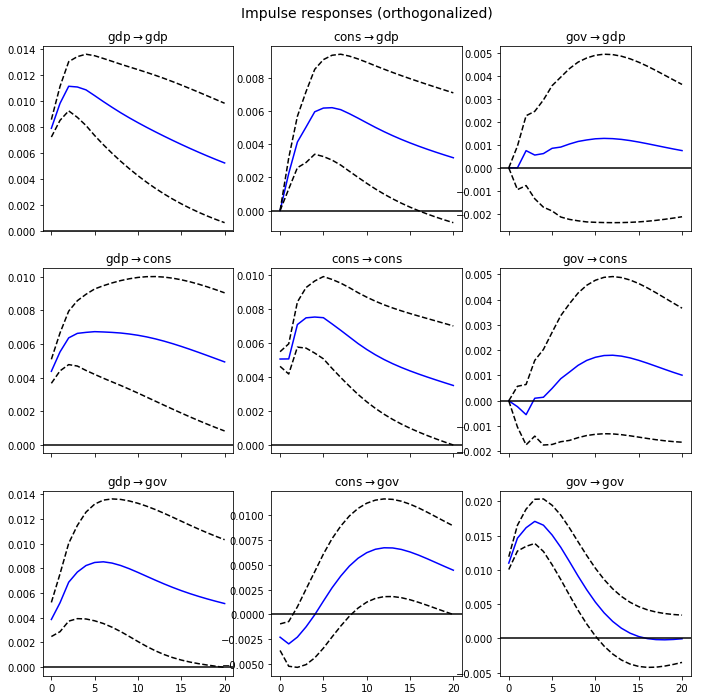

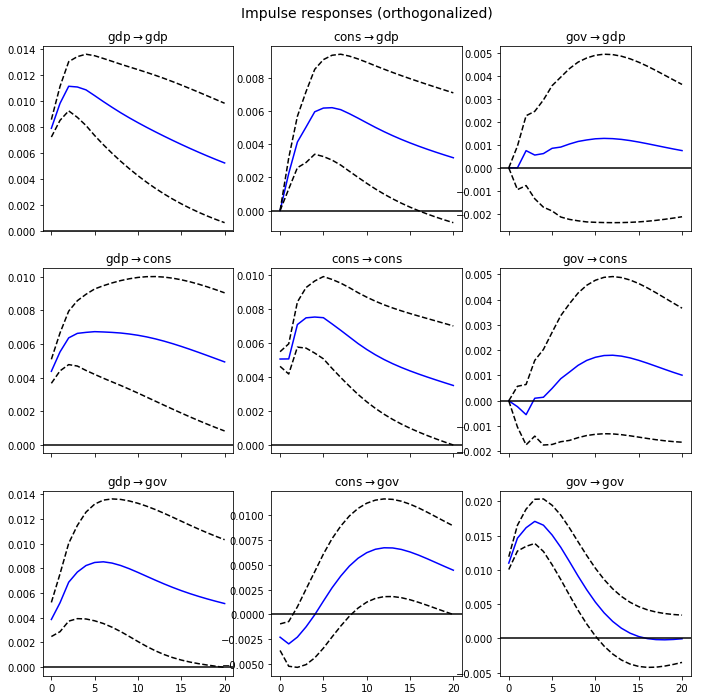

In [96]:
irf.plot(orth=True)

In [ ]:
 #define structural inputs
A = np.asarray([[1, 0, 'E'],[0, 1, 'E'],[0, 0, 1]]) #working
# B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']]) #working

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 271 entries, 1950-03-31 to 2017-09-30
Freq: Q-DEC
Data columns (total 16 columns):
gdp        271 non-null float64
cons       271 non-null float64
gov        271 non-null float64
gdp_1      271 non-null float64
gdp_2      271 non-null float64
gdp_3      271 non-null float64
gdp_4      271 non-null float64
cons_1     271 non-null float64
cons_2     271 non-null float64
cons_3     271 non-null float64
cons_4     271 non-null float64
gov_1      271 non-null float64
gov_2      271 non-null float64
gov_3      271 non-null float64
gov_4      271 non-null float64
gov_res    271 non-null float64
dtypes: float64(16)
memory usage: 36.0 KB


In [106]:
A

array([['1', '0', 'E'],
       ['0', '1', 'E'],
       ['0', '0', '1']], dtype='<U11')

In [104]:
mymodel = SVAR(df[['gdp', 'cons', 'gov']], svar_type='A', A=A, freq='Q')
res = mymodel.fit(maxlags=4, maxiter=10000, maxfun=10000, solver='bfgs', trend='ct')
res.summary()

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 24, May, 2019
Time:                     23:24:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -28.5484
Nobs:                     267.000    HQIC:                  -28.8860
Log likelihood:           2791.98    FPE:                2.27320e-13
AIC:                     -29.1127    Det(Omega_mle):     1.95008e-13
--------------------------------------------------------------------
Results for equation gdp
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.015086         0.062509           -0.241           0.809
trend           0.000018         0.000070            0.254           0.799
L1.gdp          0.998396         0.087274           11.440           0.000
L1.cons    

In [105]:
res.A

array([[ 1.       ,  0.       , -0.2163182],
       [ 0.       ,  1.       , -0.0377272],
       [ 0.       ,  0.       ,  1.       ]])

In [100]:
res.irf(periods=20)

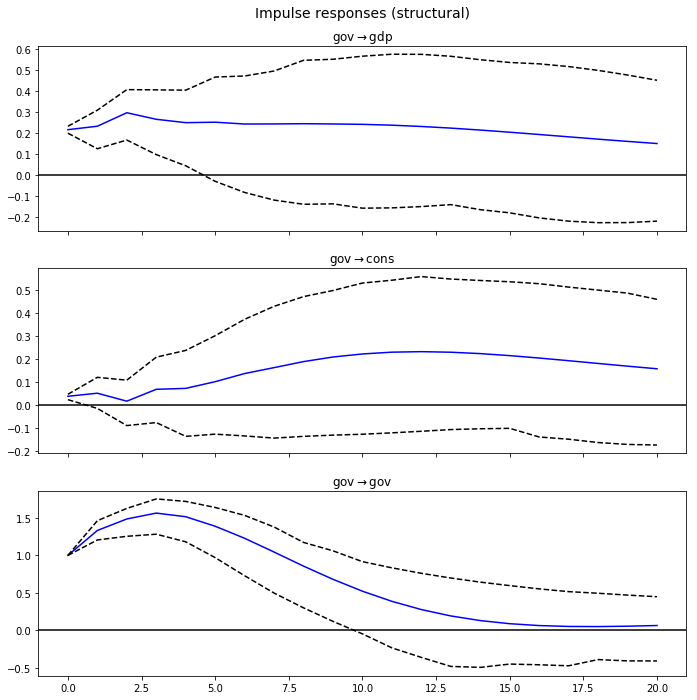

In [101]:
# https://github.com/statsmodels/statsmodels/issues/5280
# https://github.com/statsmodels/statsmodels/pull/5285/commits

# https://www.statsmodels.org/dev/vector_ar.html#module-statsmodels.tsa.vector_ar

#irf_mc = res.irf(periods=30).plot(impulse='gov', plot_stderr=True, stderr_type='mc', repl=100)
irf_asy = res.irf(periods=20).plot(impulse='gov', plot_stderr=True, stderr_type ='mc', repl=100)

In [ ]:
bla = res.irf(periods = 20)
irfunction = pd.DataFrame(bla.irfs.T[2].T)
irfunction.columns = columns
irfunction.plot()
plt.hlines(0, xmin=0, xmax=len(irfunction))
plt.xticks(np.arange(0, len(irfunction), step=1))
plt.legend(loc = 'upper right')
plt.show()

In [9]:
irfunction

,gdp,cons,gov
0,0.000000,0.000000,1.000000
1,0.000402,-0.006406,1.355330
2,0.032129,-0.069555,1.546186
3,0.025273,0.003795,1.590577
4,0.052849,-0.002083,1.552901
5,0.082771,0.025807,1.482694
6,0.105005,0.056999,1.357442
7,0.133981,0.066064,1.240567
8,0.151821,0.086085,1.120634
9,0.166031,0.092510,1.005724
